# Prediction of creditworthiness for credit card applications
## Introduction
In this project we aim to predict the creditworthiness of clients who submited a credit card application to the Pro National Bank. The goal is to create a model capable of estimating the creditworthiness of a customer, in order to help the dedicated team understand whether or not to accept the application for a credit card.


In [210]:
from tools import *
from customers_handler import Customer

## Dataset
Pro National Bank has provided two different datasets for this project. The first dataset contains information about the customers who have applied for a credit card. The second dataset contains information about the customers who have been granted a credit card. The datasets are as follows:

In [211]:
credit_df = pd.read_csv('../data/credit_record.csv')
application_df = pd.read_csv('../data/application_record.csv')
credit_df.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [212]:
application_df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [213]:
total_number_of_applications = application_df.shape[0]
total_number_of_conceeded_credit_card = credit_df['ID'].unique().shape[0]
print(total_number_of_applications)
print(total_number_of_conceeded_credit_card)

438557
45985


The two datasets are composed by respectively 438557 and 13153 clients.
The application dataset contains the following features:
- `ID`: the unique identifier of the client;
- `CODE_GENDER`: the client gender;
- `FLAG_OWN_CAR`: whether the client owns a car or not;
- `FLAG_OWN_REALTY`: whether the client owns a realty or not;
- `CNT_CHILDREN`: the number of children the client has;
- `AMT_INCOME_TOTAL`: the total income of the client;
- `NAME_INCOME_TYPE`: the type of income of the client;
- `NAME_EDUCATION_TYPE`: the education level of the client;
- `NAME_FAMILY_STATUS`: the family status of the client;
- `NAME_HOUSING_TYPE`: the housing type of the client;
- `DAYS_BIRTH`: the age of the client in days, relative to the application date (negative value);
- `DAYS_EMPLOYED`: the number of days the client has been employed, relative to the application date (negative value if the client is employed);
- `FLAG_MOBIL`: whether the client provided a mobile phone number or not;
- `FLAG_WORK_PHONE`: whether the client provided a work phone number or not;
- `FLAG_PHONE`: whether the client provided a phone number or not;
- `FLAG_EMAIL`: whether the client provided an email or not;
- `OCCUPATION_TYPE`: the occupation of the client;
- `CNT_FAM_MEMBERS`: the number of family members of the client.<br><br>


The credit card dataset contains the following features:
- `ID`: the unique identifier of the client;
- `MONTHS_BALANCE`: the month of the record relative to the application date;
- `STATUS`: the status of the credit card of the client, where 0 means 1-29 days past due, 1 means 30-59 days past due, 2 means 60-89 days overdue, 
3 means 90-119 days overdue, 4 means 120-149 days overdue, 5 means over 150 days overdue, and C means paid off that month and X means no loan for the month.


In [214]:
credit_df = credit_df[credit_df['ID'].isin(application_df['ID'])]
credit_df.reset_index(drop=True, inplace=True)
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5008804,0,C
1,5008804,-1,C
2,5008804,-2,C
3,5008804,-3,C
4,5008804,-4,C


## Datasets exploration and cleaning
In this section we will explore the datasets in order to understand the data and the features we have at our disposal.
Starting from *credit_df*, we can see that for every ID there can be multiple entries, each one representing a different month of the credit card status.
The first thing we can do is select valid IDs from the dataset in order to consider only customers with a history large enough to provide sufficient information on the client's status to get the full picture of the client's reliability. We decided to consider only the clients with **at least 24 months** of history, which is the minimum number of months required to have a full picture of the client's status.

In [215]:
credit_df['ID'].value_counts()

ID
5148819    61
5115964    61
5061741    61
5078799    61
5061685    61
           ..
5139553     1
5069020     1
5097025     1
5023604     1
5092141     1
Name: count, Length: 36457, dtype: int64

In [216]:
value_counts = credit_df['ID'].value_counts()
idx = value_counts[value_counts > 24].index
credit_df = credit_df[credit_df["ID"].isin(idx)]

credit_df.reset_index(drop=True, inplace=True)
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5008806,0,C
1,5008806,-1,C
2,5008806,-2,C
3,5008806,-3,C
4,5008806,-4,C


Once obtained the valid IDs, we can extract from the *application_df* dataframe the subset of application requests that have already been accepted by the bank.
We call this new dataframe *approved_applications*. 

In [217]:
approved_applications = application_df[np.isin(application_df['ID'], credit_df['ID'])]
approved_applications.reset_index(drop=True, inplace=True)
approved_applications.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
1,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
2,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
3,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0
4,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
5,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
6,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0
7,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0
8,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.0
9,5008838,M,N,Y,1,405000.0,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3.0


We can now obserse the distribution of the features in the *approved_applications* dataframe, in order to understand the characteristics of the clients who have been granted a credit card.
First of all, we can see that there are some missing values in the **OCCUPATION_TYPE** column and in particular, we observe a missing of 4068 values, which is a significant amount of missing data.
Before decide how to handle the missing values, we can observe the distribution of the other features in the dataframe.

In [218]:
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13153 non-null  int64  
 1   CODE_GENDER          13153 non-null  object 
 2   FLAG_OWN_CAR         13153 non-null  object 
 3   FLAG_OWN_REALTY      13153 non-null  object 
 4   CNT_CHILDREN         13153 non-null  int64  
 5   AMT_INCOME_TOTAL     13153 non-null  float64
 6   NAME_INCOME_TYPE     13153 non-null  object 
 7   NAME_EDUCATION_TYPE  13153 non-null  object 
 8   NAME_FAMILY_STATUS   13153 non-null  object 
 9   NAME_HOUSING_TYPE    13153 non-null  object 
 10  DAYS_BIRTH           13153 non-null  int64  
 11  DAYS_EMPLOYED        13153 non-null  int64  
 12  FLAG_MOBIL           13153 non-null  int64  
 13  FLAG_WORK_PHONE      13153 non-null  int64  
 14  FLAG_PHONE           13153 non-null  int64  
 15  FLAG_EMAIL           13153 non-null 

An anomaly is detected in the data. The column **DAYS_EMPLOYED** has a value of 365243 for some of the records. This value is not possible as it would mean that the person has been working for 1000 years. Looking more carefully at the data, we can see that the value 365243 is present only for the clients who are retired (2150 clients).  

In [219]:
for column in approved_applications.columns:
    if column == "ID":
        continue
    print("--------------------")
    print(column, approved_applications[column].nunique())
    print(approved_applications[column].value_counts())
    print("--------------------")
    

--------------------
CODE_GENDER 2
CODE_GENDER
F    8743
M    4410
Name: count, dtype: int64
--------------------
--------------------
FLAG_OWN_CAR 2
FLAG_OWN_CAR
N    7903
Y    5250
Name: count, dtype: int64
--------------------
--------------------
FLAG_OWN_REALTY 2
FLAG_OWN_REALTY
Y    8584
N    4569
Name: count, dtype: int64
--------------------
--------------------
CNT_CHILDREN 7
CNT_CHILDREN
0     9141
1     2620
2     1207
3      162
4       17
5        4
14       2
Name: count, dtype: int64
--------------------
--------------------
AMT_INCOME_TOTAL 194
AMT_INCOME_TOTAL
135000.0    1517
180000.0    1221
112500.0    1040
225000.0    1017
157500.0    1009
            ... 
191250.0       1
531000.0       1
634500.0       1
165150.0       1
215100.0       1
Name: count, Length: 194, dtype: int64
--------------------
--------------------
NAME_INCOME_TYPE 5
NAME_INCOME_TYPE
Working                 6697
Commercial associate    3134
Pensioner               2157
State servant           1

In [224]:
print(approved_applications[approved_applications['DAYS_EMPLOYED'] == 0].shape[0])
(approved_applications[(approved_applications['DAYS_EMPLOYED'] > 0) & (approved_applications['NAME_INCOME_TYPE'] == 'Pensioner')].shape)[0]

0


2150

For those clients, we replace the NaN value of **OCCUPATION_TYPE** with the string 'Unemployed', and let see if all the missing values have been filled.

In [223]:
approved_applications.loc[approved_applications['DAYS_EMPLOYED'] > 0, 'OCCUPATION_TYPE'] = "Unemployed"
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13153 non-null  int64  
 1   CODE_GENDER          13153 non-null  object 
 2   FLAG_OWN_CAR         13153 non-null  object 
 3   FLAG_OWN_REALTY      13153 non-null  object 
 4   CNT_CHILDREN         13153 non-null  int64  
 5   AMT_INCOME_TOTAL     13153 non-null  float64
 6   NAME_INCOME_TYPE     13153 non-null  object 
 7   NAME_EDUCATION_TYPE  13153 non-null  object 
 8   NAME_FAMILY_STATUS   13153 non-null  object 
 9   NAME_HOUSING_TYPE    13153 non-null  object 
 10  DAYS_BIRTH           13153 non-null  int64  
 11  DAYS_EMPLOYED        13153 non-null  int64  
 12  FLAG_MOBIL           13153 non-null  int64  
 13  FLAG_WORK_PHONE      13153 non-null  int64  
 14  FLAG_PHONE           13153 non-null  int64  
 15  FLAG_EMAIL           13153 non-null 

In [ ]:
print("Percentage of Nan values in occupation type: %.2f%%" % (approved_applications['OCCUPATION_TYPE'].isna().sum() *100 /approved_applications.shape[0]))

In [181]:
approved_applications = approved_applications.drop(columns=["OCCUPATION_TYPE"])

Since the **OCCUPATION_TYPE** still presents a strong percentage of missing values and there are a couple of columns that already contain information about the client's income, we decide to drop the **OCCUPATION_TYPE** column from the dataframe.<br>
Moreover, we rename the **DAYS_BIRTH** column to **AGE** and the **DAYS_EMPLOYED** column to **YEARS_EMPLOYED**, and perform the appropriate transformations in order to make the dataframe more readable.
In particular we take the positive values of **DAYS_EMPLOYED** and set them to 0, since they represent the clients who are retired, and then we converted the negative days into positive years.
Moreover we removed columns **GENDER** and **CNT_CHILDREN** since: the first is not relevant for the analysis, the second is already included in the **CNT_FAM_MEMBERS** column.

In [ ]:
approved_applications = preprocess_dataframe(approved_applications)

Let see the distribution of the features in the dataframe after the cleaning:
* *approved_applications* dataframe:

In [173]:
approved_applications.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,Security staff,2.0
1,5008810,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0
2,5008811,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0
3,5112956,Y,Y,270000.0,Working,Higher education,Married,House / apartment,46,2,1,1,1,1,Accountants,2.0
4,5008825,Y,N,130500.0,Working,Incomplete higher,Married,House / apartment,29,3,1,0,0,0,Accountants,2.0


* *credit_df* dataframe:

In [226]:
print("Unique ID : ", credit_df['ID'].nunique())
print(credit_df['MONTHS_BALANCE'].value_counts())

Unique ID :  13153
MONTHS_BALANCE
-24    12877
-23    12819
-22    12765
-21    12696
-20    12628
       ...  
-56     1153
-57      903
-58      688
-59      462
-60      234
Name: count, Length: 61, dtype: int64


and then we can see credit information of client with ID 5008810, for example, in the *credit_df* dataframe:

In [227]:
credit_df[credit_df['ID'] == 5008810]

,ID,MONTHS_BALANCE,STATUS
30,5008810,0,C
31,5008810,-1,C
32,5008810,-2,C
33,5008810,-3,C
34,5008810,-4,C
35,5008810,-5,C
36,5008810,-6,C
37,5008810,-7,C
38,5008810,-8,C
39,5008810,-9,C


Let see some statistics of numerical variables of the cleaned dataframe:

In [175]:
round(approved_applications[["AMT_INCOME_TOTAL", "AGE", "YEARS_EMPLOYED", "CNT_FAM_MEMBERS"]].describe(), 2)

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS
count,13153.00,13153.00,13153.00,13153.00
mean,189267.09,43.91,6.17,2.22
std,102034.01,11.07,6.76,0.90
min,27000.00,22.00,0.00,1.00
25%,126000.00,35.00,1.00,2.00
50%,166500.00,43.00,4.00,2.00
75%,225000.00,53.00,9.00,3.00
max,1575000.00,68.00,42.00,15.00


## Creditworthiness computation

In order to compute the creditworthiness of the clients, we need to create a new feature that represents the creditworthiness of the client. 
We can use the **STATUS** column of the *credit_df* dataframe to compute the creditworthiness of the clients. We can define the creditworthiness of 
a client as the percentage of months in which the client has been in a good standing position, i.e. the percentage of months in which the client has 
not been in a delayed position. We can compute this percentage for each client and then use it as a feature to predict the creditworthiness of the client. 
Moreover we can use the **MONTHS_BALANCE** column to compute the number of months of history of the client, which is a useful feature to understand the reliability 
of the client.
We finally can consider the last 6 months of the client's history to understand the creditworthiness trend of the client.
In **customers_handler/Customer.py** we define the class Customer, which contains the method *compute_reliability* that computes the creditworthiness of the client.
The reliability is computed in a range from 0 to 7, where 0 means that the client has definitely a bad creditworthiness and 7 means that the client has a strong creditworthiness. To be considered a good client, the client must have a reliability of at least 5.
As described in method *get_history_reliability*, if the client:
1. has a percentage higher than 5% of "over 150 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 0; 
2. has a percentage higher than 5% of "120-149 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 1. 
3. has a percentage higher than 10% of "90-119 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 2.
4. has a percentage between 5 and 10% of "90-119 days overdue" status or higher than 15% of "60-89 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 3.
5. has a percentage between 5 and 15% of "60-89 days overdue" status or higher than 15% of "30-59 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 4.
6. has a percentage between 5 and 15% of "30-59 days overdue" status or higher than 15% of "1-29 days overdue" status, the client is considered to have a good creditworthiness and the reliability is set to 5.
7. has a percentage between 5 and 15% of "1-29 days overdue" status or lower than 70% of "paid off month" status, the client is considered to have a good creditworthiness and the reliability is set to 6.
8. has at least 70% of "paid off month" status, the client is considered to have a good creditworthiness and the reliability is set to 7.<br>

Then the reliability of last 6 months is computed as follow:
1. if the client has at least 1 month of "over 150 days overdue" or "120-149 days overdue" status, the reliability is set to 0;
2. if the client has at least 1 month of "90-119 days overdue" status, the reliability is set to 1;
3. if the client has at least 1 month of "60-89 days overdue" status, the reliability is set to 2;
4. if the client has at least 1 month of "30-59 days overdue" status, the reliability is set to 3;
5. if the client has at least 1 month of "1-29 days overdue" status, the reliability is set to 4;
6. if the client has at least 1 month of "no loan for the month" status, the reliability is set to 5.
7. if the client has at least 1 month of "no loan for the month" status, the reliability is set to 6.

### DA RIVEDEREEEEEEEEEEEE

In [176]:
ids = approved_applications['ID'].unique()
customers_creditworthiness = { "CUSTOMER_RELIABILITY": [], "BAD_CUSTOMER": []}

for id in ids:
    client=Customer(id, approved_applications[(approved_applications['ID'] == id).drop(columns=['ID'])], credit_df[(credit_df['ID'] == id).drop(columns=['ID'])])
    customers_creditworthiness["CUSTOMER_RELIABILITY"].append(client.get_reliability())
    customers_creditworthiness["BAD_CUSTOMER"].append(client.get_bad_client())

approved_applications = approved_applications.join(pd.DataFrame(customers_creditworthiness))
       

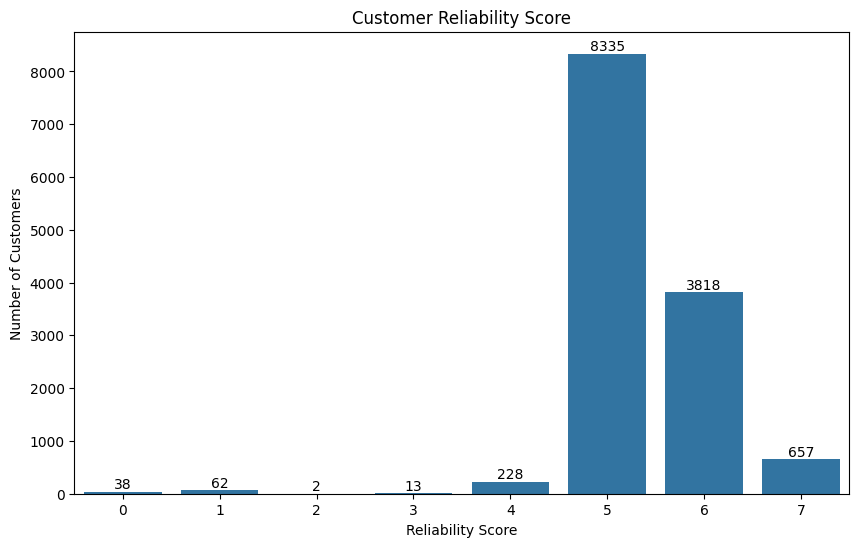

In [177]:
_, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='CUSTOMER_RELIABILITY', data=approved_applications)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.xlabel('Reliability Score')
plt.ylabel('Number of Customers')
plt.title('Customer Reliability Score')
plt.show()



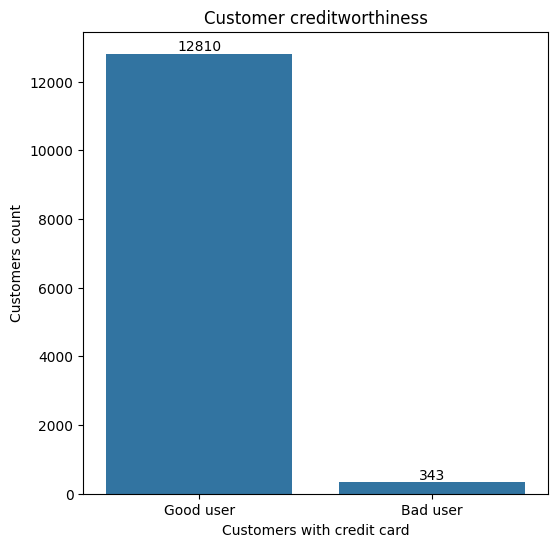

In [178]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.countplot(x='BAD_CUSTOMER', data=approved_applications)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Good user', 'Bad user'])
plt.xlabel('Customers with credit card')
plt.ylabel('Customers count')
plt.title('Customer creditworthiness')
plt.show()

In [179]:
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    13153 non-null  int64  
 1   FLAG_OWN_CAR          13153 non-null  object 
 2   FLAG_OWN_REALTY       13153 non-null  object 
 3   AMT_INCOME_TOTAL      13153 non-null  float64
 4   NAME_INCOME_TYPE      13153 non-null  object 
 5   NAME_EDUCATION_TYPE   13153 non-null  object 
 6   NAME_FAMILY_STATUS    13153 non-null  object 
 7   NAME_HOUSING_TYPE     13153 non-null  object 
 8   AGE                   13153 non-null  int64  
 9   YEARS_EMPLOYED        13153 non-null  int64  
 10  FLAG_MOBIL            13153 non-null  int64  
 11  FLAG_WORK_PHONE       13153 non-null  int64  
 12  FLAG_PHONE            13153 non-null  int64  
 13  FLAG_EMAIL            13153 non-null  int64  
 14  OCCUPATION_TYPE       11235 non-null  object 
 15  CNT_FAM_MEMBERS    

In [182]:
columns_of_interest = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']
cross_tab = []
for column in columns_of_interest:
    cross_tab.append(pd.crosstab(approved_applications['CUSTOMER_RELIABILITY'], approved_applications[column]))
    display(cross_tab[-1])

NAME_INCOME_TYPE,Commercial associate,Pensioner,State servant,Student,Working
CUSTOMER_RELIABILITY,,,,,
0,15,6,1,0,16
1,13,18,6,0,25
2,1,0,0,0,1
3,5,2,0,0,6
4,64,28,19,0,117
5,2014,1368,765,2,4186
6,872,615,312,6,2013
7,150,120,54,0,333


NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
CUSTOMER_RELIABILITY,,,,,
0,0,11,5,0,22
1,0,16,2,3,41
2,0,0,0,0,2
3,0,3,2,0,8
4,0,57,21,2,148
5,8,2298,307,94,5628
6,5,1101,145,41,2526
7,5,178,23,12,439


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Widow
CUSTOMER_RELIABILITY,,,,,
0,1,27,3,5,2
1,1,47,3,9,2
2,0,0,1,1,0
3,0,9,0,3,1
4,21,143,16,39,9
5,614,5946,469,968,338
6,307,2727,224,396,164
7,52,451,38,93,23


FLAG_OWN_REALTY,N,Y
CUSTOMER_RELIABILITY,,
0,10,28
1,26,36
2,1,1
3,4,9
4,108,120
5,2891,5444
6,1320,2498
7,209,448


FLAG_OWN_CAR,N,Y
CUSTOMER_RELIABILITY,,
0,25,13
1,42,20
2,2,0
3,8,5
4,143,85
5,5057,3278
6,2209,1609
7,417,240


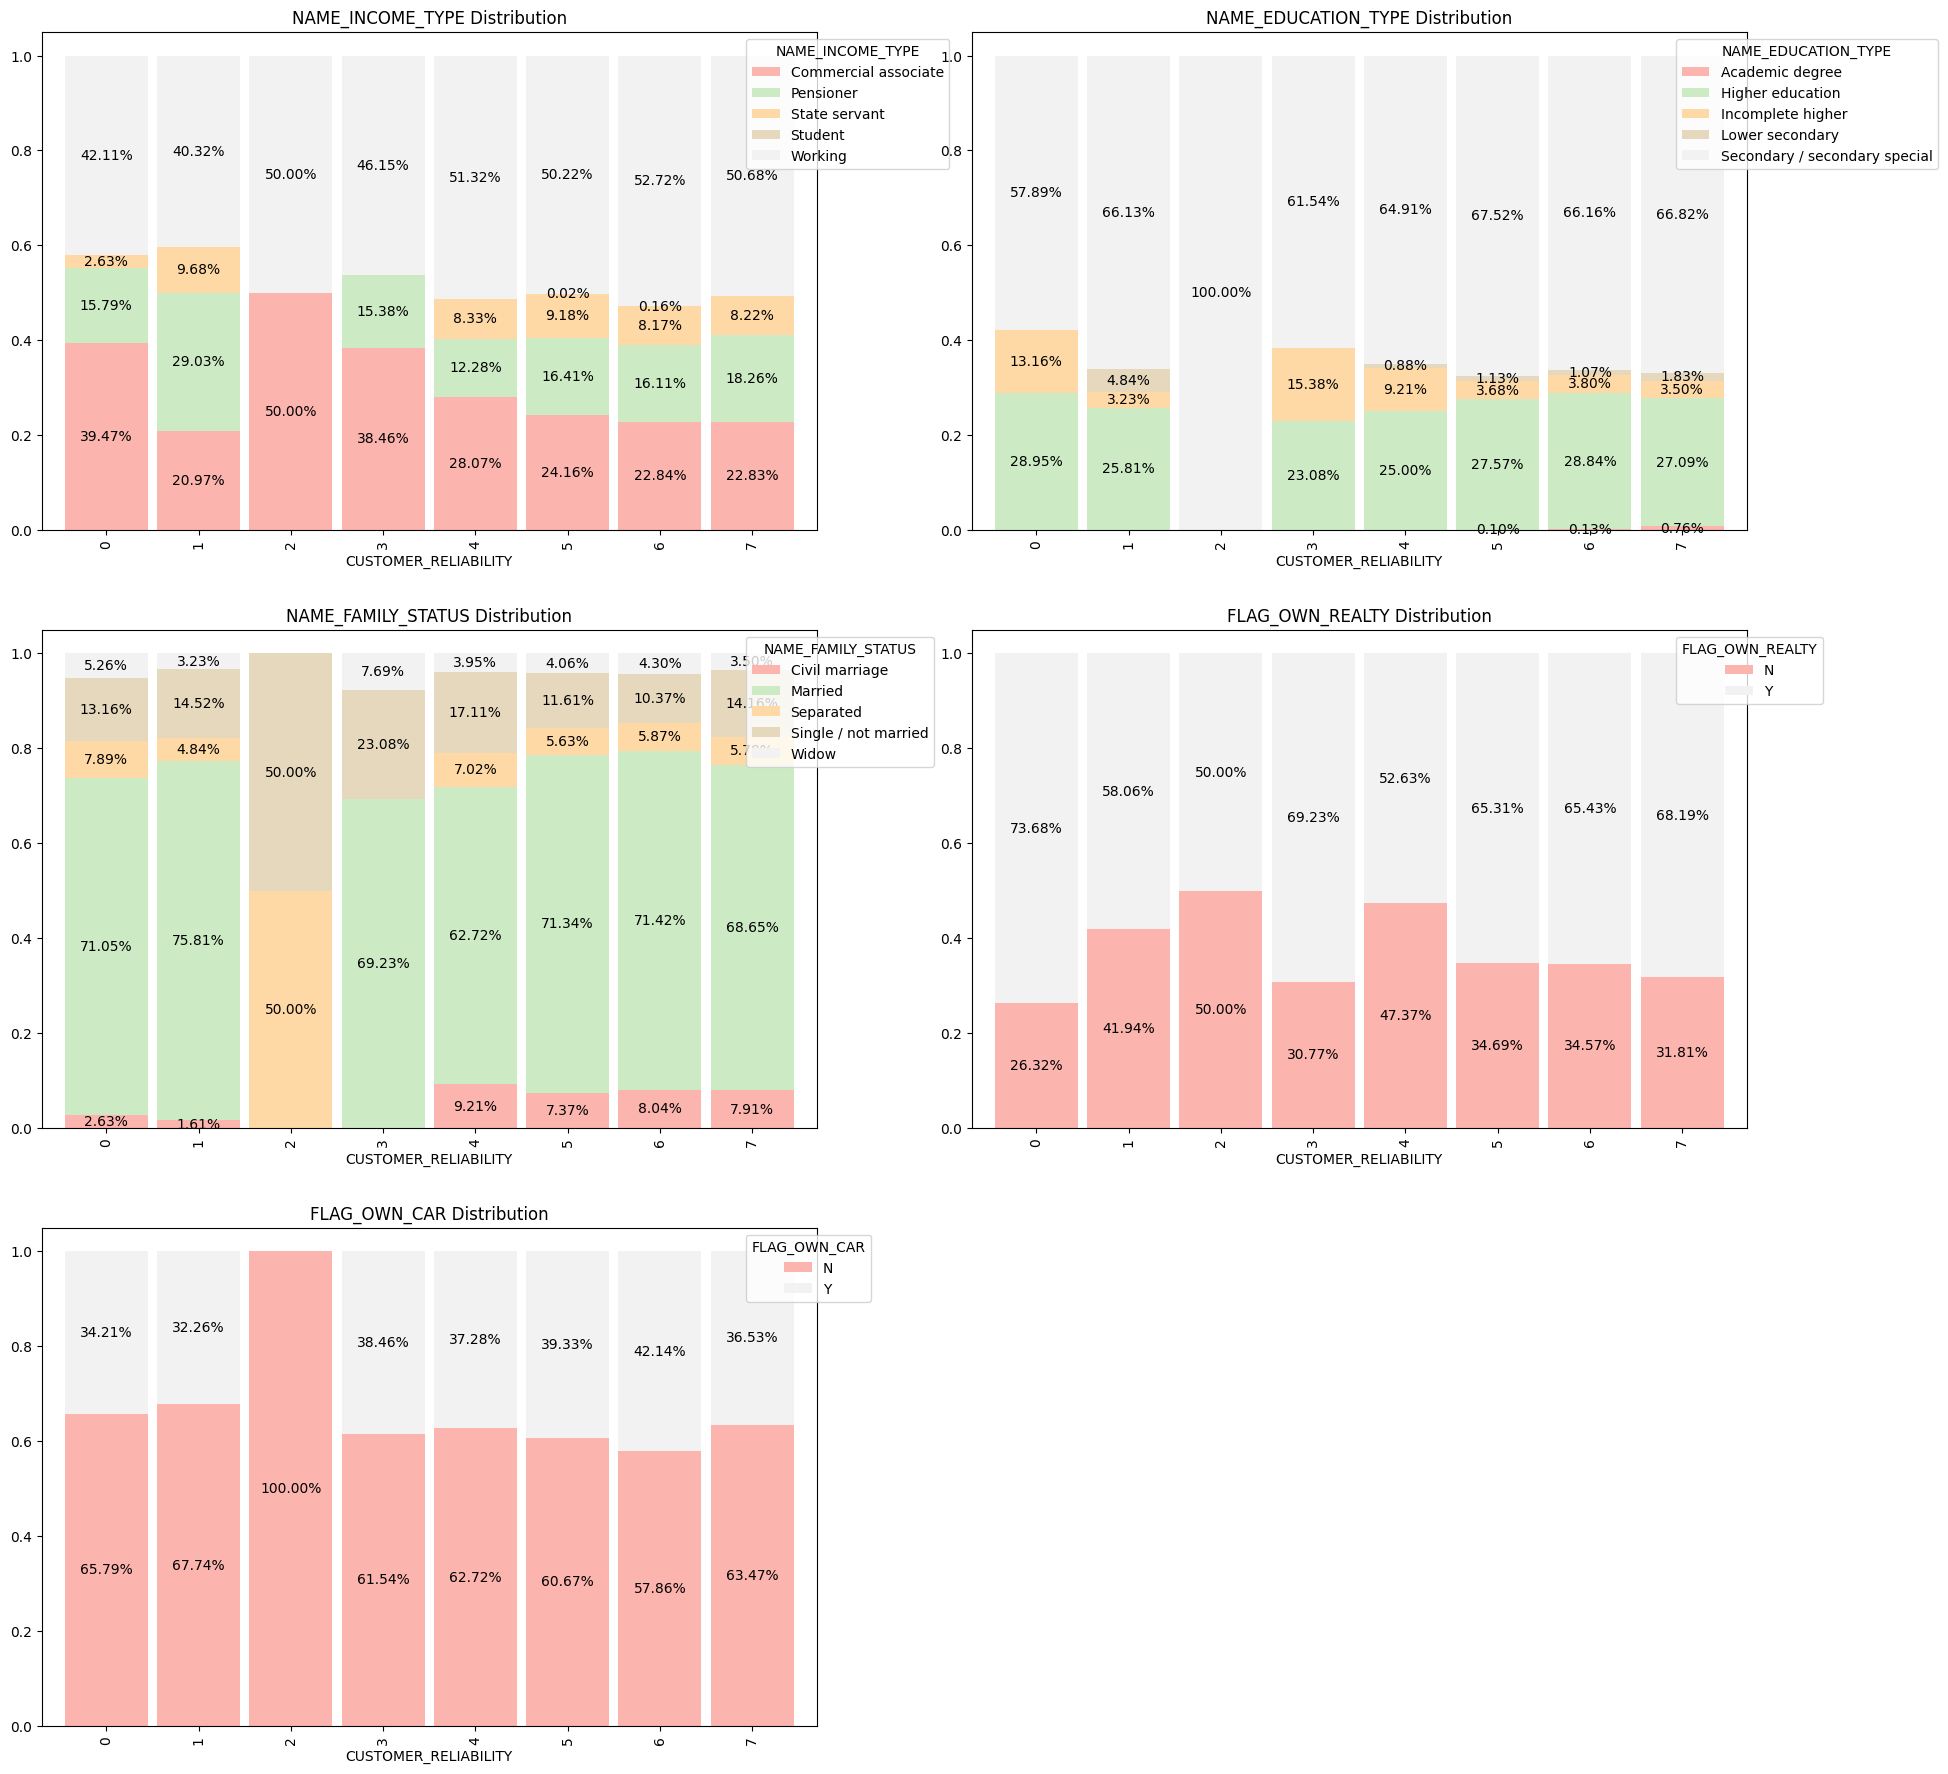

In [183]:
subplot = 0
axes = []
fig, axes = plt.subplots(3,2, figsize=(22, 22))
for column in columns_of_interest:
    cross_tab = pd.crosstab(approved_applications['CUSTOMER_RELIABILITY'], approved_applications[column])
    cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    cross_tab_plot = cross_tab.plot(kind='bar', stacked=True, width=0.9, ax=axes[int(subplot/2)][subplot%2], colormap='Pastel1')
    axes[int(subplot/2)][subplot%2].legend(title=column, bbox_to_anchor=(0.9, 1), loc='upper left')
    show_percentage(cross_tab_plot, cross_tab)
    plt.xlabel('Reliability Score')
    plt.ylabel('Percentage')
    axes[int(subplot/2)][subplot%2].set_title(column + ' Distribution')
    subplot += 1
axes[-1, -1].axis('off')
plt.show() 

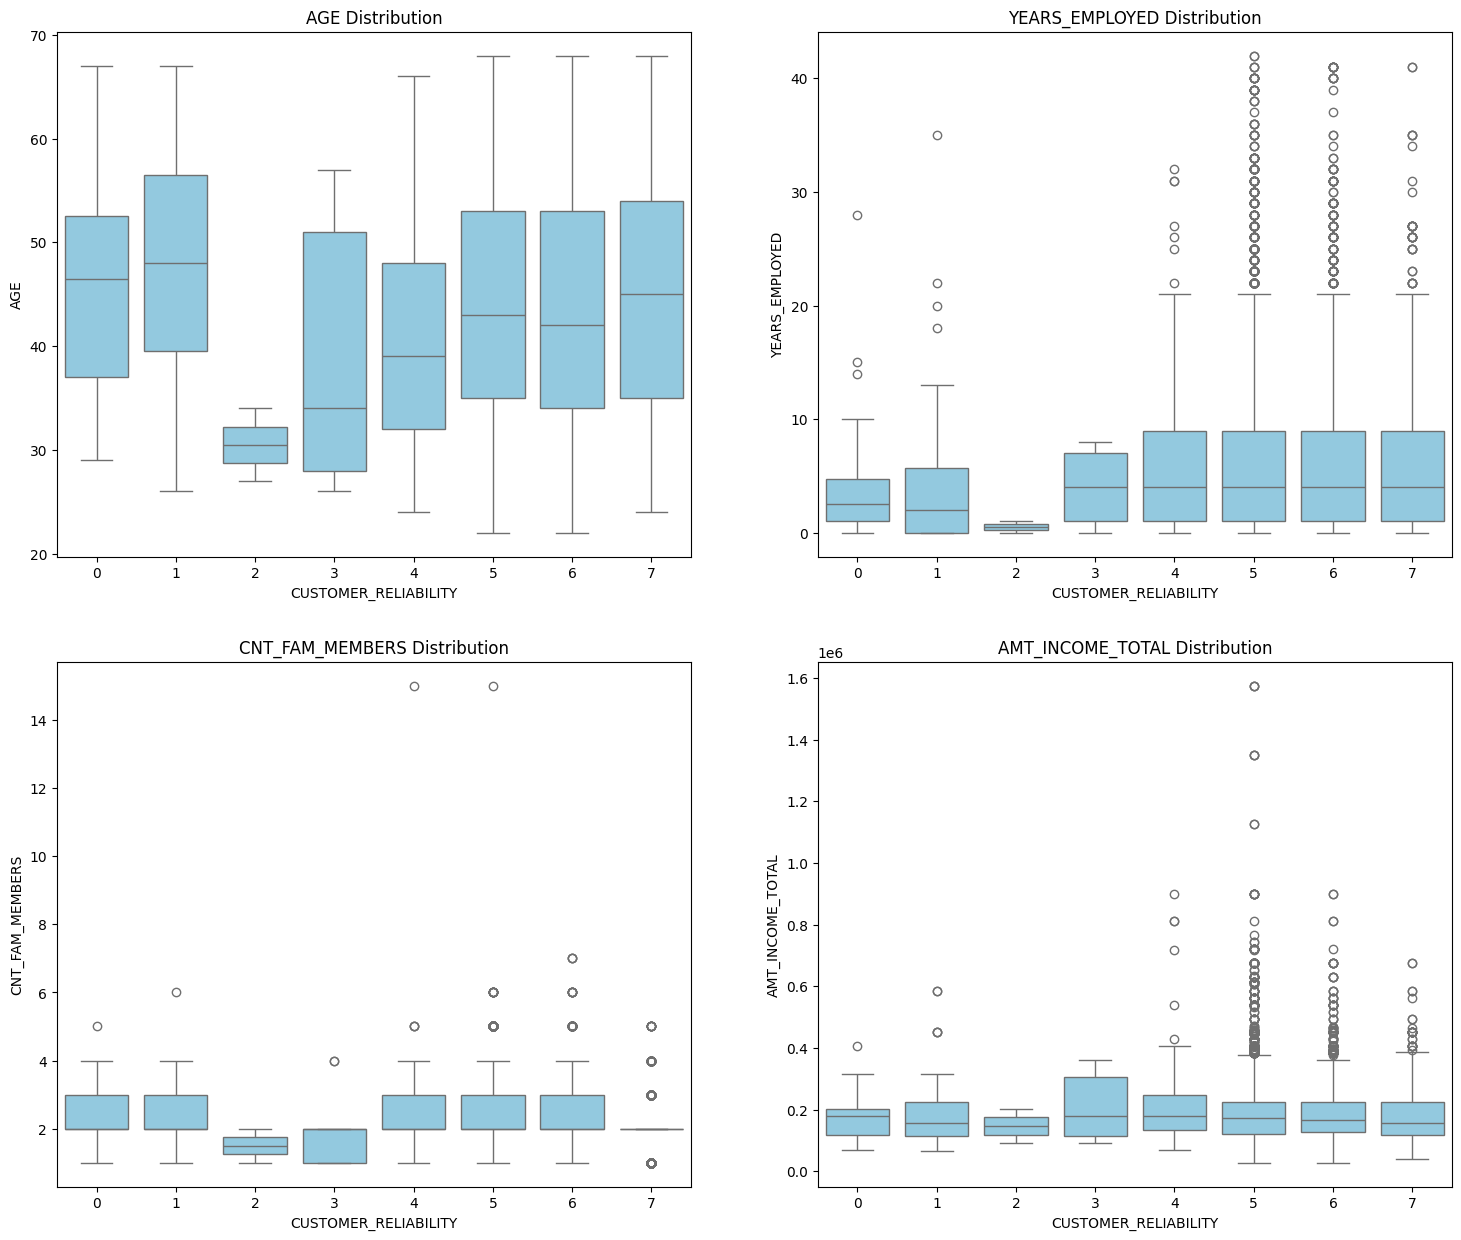

In [184]:
numerical_columns = ['AGE', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL']
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for i, column in enumerate(numerical_columns):
    sns.boxplot(x='CUSTOMER_RELIABILITY', y=column, data=approved_applications, ax=axes[int(i/2)][i%2], color='skyblue')
    axes[int(i/2)][i%2].set_title(column + ' Distribution')
plt.show()


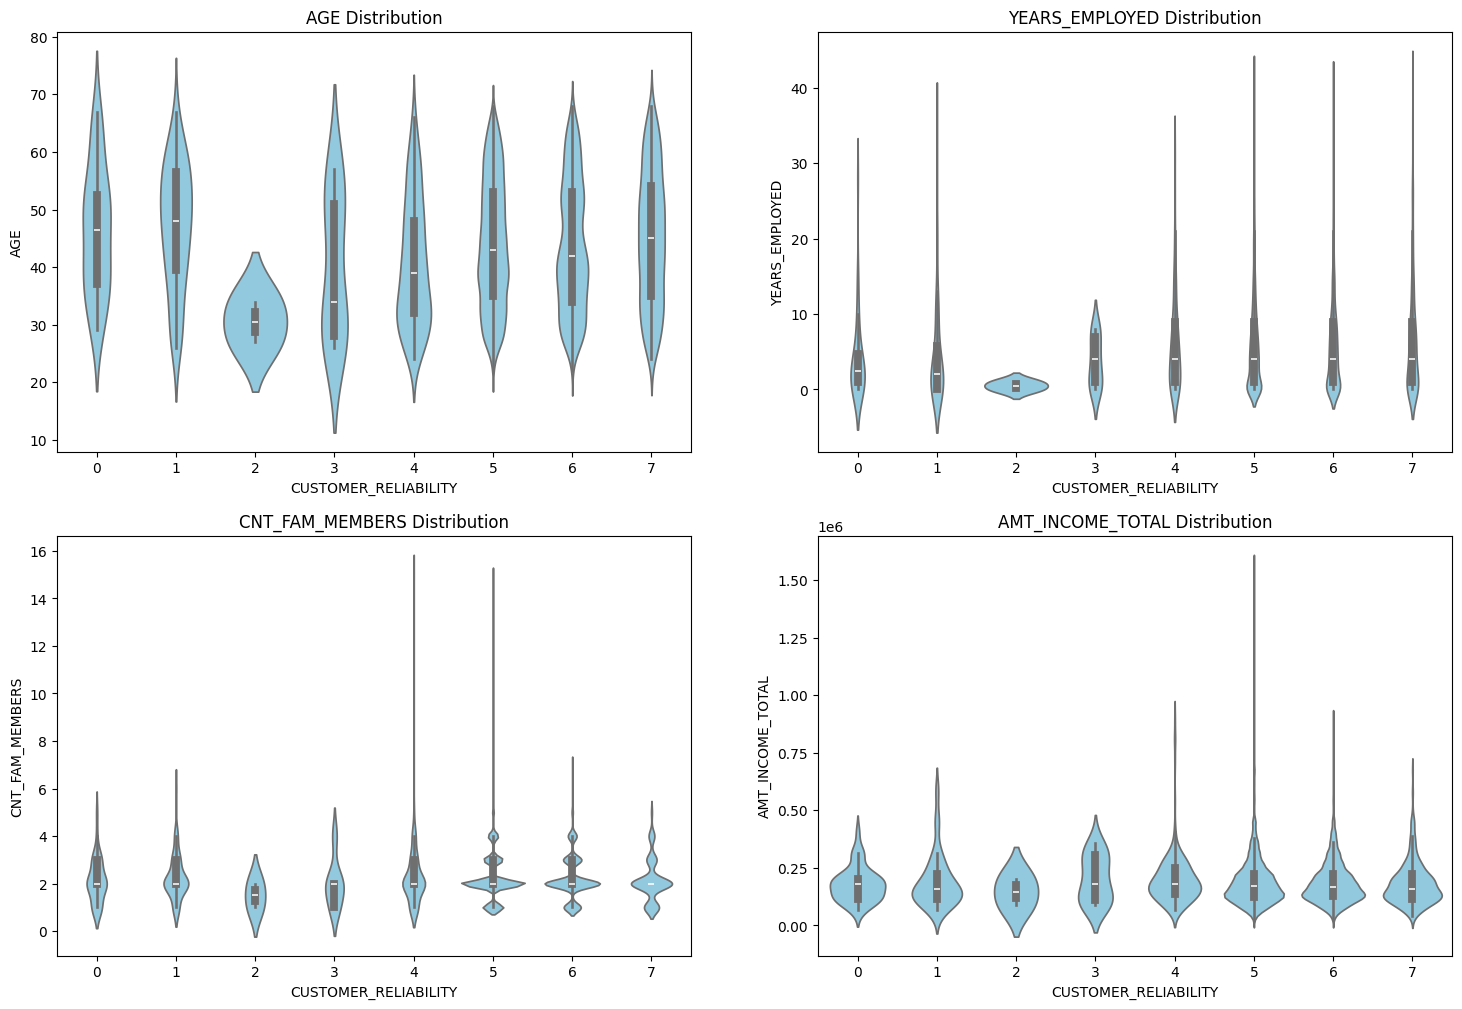

In [185]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i, column in enumerate(numerical_columns):
    sns.violinplot(x='CUSTOMER_RELIABILITY', y=column, data=approved_applications, ax=axes[int(i/2)][i%2], color='skyblue')
    axes[int(i/2)][i%2].set_title(column + ' Distribution')

In [186]:
pd.crosstab(approved_applications['BAD_CUSTOMER'], approved_applications["NAME_EDUCATION_TYPE"][approved_applications["NAME_EDUCATION_TYPE"].isin(['Academic degree'])])

NAME_EDUCATION_TYPE,Academic degree
BAD_CUSTOMER,
0,18


In [187]:

columns_to_ordinal_encode = ["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
columns_to_one_hot_encode = ["NAME_FAMILY_STATUS", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE"]
columns_to_scale = ["AMT_INCOME_TOTAL", "AGE", "YEARS_EMPLOYED", "CNT_FAM_MEMBERS"]
columns_not_to_encode = ["FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]

X = approved_applications.drop(columns=['ID', 'CUSTOMER_RELIABILITY', 'BAD_CUSTOMER', 'FLAG_MOBIL', "NAME_HOUSING_TYPE"])
y = approved_applications['BAD_CUSTOMER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

column_transformer = ColumnTransformer([
    ('ORDINAL', OrdinalEncoder( ), columns_to_ordinal_encode),
    ('OHE', OneHotEncoder(sparse_output=False), columns_to_one_hot_encode),
    ], 
    remainder='passthrough')

column_transformer.set_output(transform='pandas')
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)
X_train = X_train.astype('int64')
X_test = X_test.astype('int64')


In [188]:
rename_column_without_prefix(X_train, X_test, prefix="remainder__")
rename_column_without_prefix(X_train, X_test, prefix="ORDINAL__")
rename_column_without_prefix(X_train, X_test, prefix="OHE__NAME_")

Text(0.5, 1.0, 'Correlation Matrix')

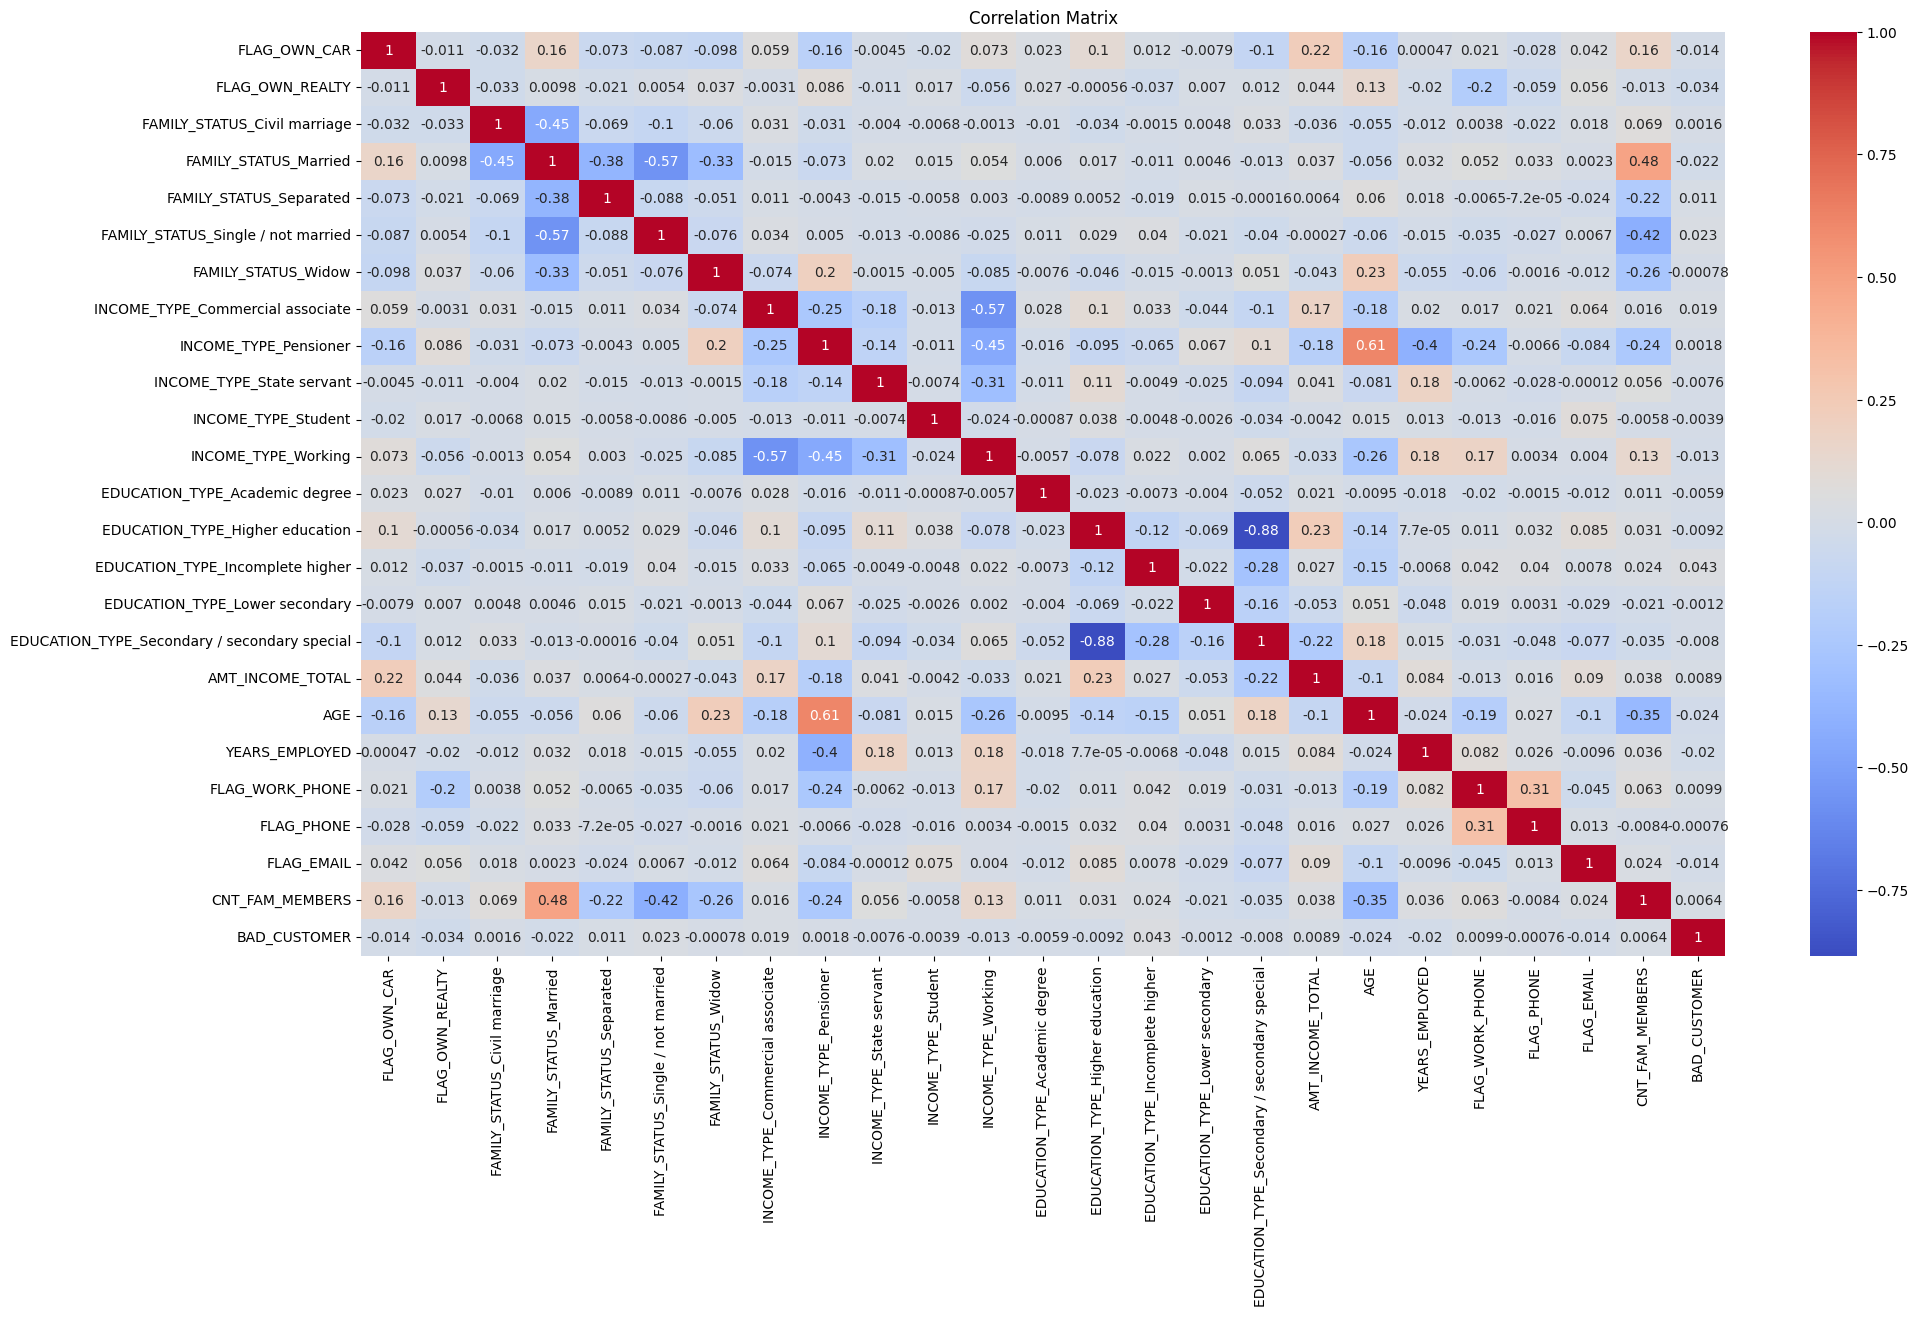

In [189]:
temp_df = X_train.join(y_train)
corr = temp_df.corr()
_, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")
plt.title("Correlation Matrix")

In [190]:
X_train_rf = X_train[["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "AGE", "YEARS_EMPLOYED", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS", "INCOME_TYPE_Pensioner", "INCOME_TYPE_Student", "EDUCATION_TYPE_Academic degree", "FAMILY_STATUS_Married", "FAMILY_STATUS_Single / not married", "EDUCATION_TYPE_Higher education"]]
X_test_rf  =  X_test[["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "AGE", "YEARS_EMPLOYED", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS", "INCOME_TYPE_Pensioner", "INCOME_TYPE_Student", "EDUCATION_TYPE_Academic degree", "FAMILY_STATUS_Married", "FAMILY_STATUS_Single / not married", "EDUCATION_TYPE_Higher education"]]


In [191]:
std_scaler_transformer = ColumnTransformer([
    ('STD_SCALER', StandardScaler(), columns_to_scale)
    ], 
    remainder='passthrough')
std_scaler_transformer.set_output(transform='pandas')
X_train_std = std_scaler_transformer.fit_transform(X_train_rf)
X_test_std = std_scaler_transformer.transform(X_test_rf)
X_train_std = X_train_std.astype('int64')
X_test_std = X_test_std.astype('int64')
rename_column_without_prefix(X_train_std, X_test_std, prefix="remainder__")
X_train_std.head()


,STD_SCALER__AMT_INCOME_TOTAL,STD_SCALER__AGE,STD_SCALER__YEARS_EMPLOYED,STD_SCALER__CNT_FAM_MEMBERS,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_TYPE_Pensioner,INCOME_TYPE_Student,EDUCATION_TYPE_Academic degree,FAMILY_STATUS_Married,FAMILY_STATUS_Single / not married,EDUCATION_TYPE_Higher education
11443,0,0,0,0,0,1,0,0,0,1,0,0
9752,0,1,0,0,0,1,0,0,0,1,0,1
5632,0,0,0,1,0,1,0,0,0,0,0,0
7700,0,1,0,0,0,1,1,0,0,1,0,0
9208,0,0,0,0,0,1,0,0,0,1,0,0


In [192]:
print(approved_applications["BAD_CUSTOMER"].value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

BAD_CUSTOMER
0    12810
1      343
Name: count, dtype: int64
BAD_CUSTOMER
0    10254
1      268
Name: count, dtype: int64
BAD_CUSTOMER
0    2556
1      75
Name: count, dtype: int64


In [193]:
smote = SMOTE(sampling_strategy=0.7, random_state=RANDOM_STATE)
X_train_std_smt, y_train_smote = smote.fit_resample(X_train_std, y_train)
print("SMOTE: ", y_train_smote.value_counts())

rus = RandomUnderSampler(sampling_strategy=0.75, random_state=RANDOM_STATE)
X_train_stdrus, y_train_rus = rus.fit_resample(X_train_std, y_train)
print("Undersampling: ", y_train_rus.value_counts())


SMOTE:  BAD_CUSTOMER
0    10254
1     7177
Name: count, dtype: int64
Undersampling:  BAD_CUSTOMER
0    357
1    268
Name: count, dtype: int64


Train Set Accuracy:  0.58
              precision    recall  f1-score   support

           0       0.68      0.55      0.61     10254
           1       0.50      0.63      0.56      7177

    accuracy                           0.58     17431
   macro avg       0.59      0.59      0.58     17431
weighted avg       0.61      0.58      0.59     17431

--------------------
Test Set Accuracy:  0.54
              precision    recall  f1-score   support

           0       0.98      0.54      0.69      2556
           1       0.04      0.60      0.07        75

    accuracy                           0.54      2631
   macro avg       0.51      0.57      0.38      2631
weighted avg       0.95      0.54      0.68      2631



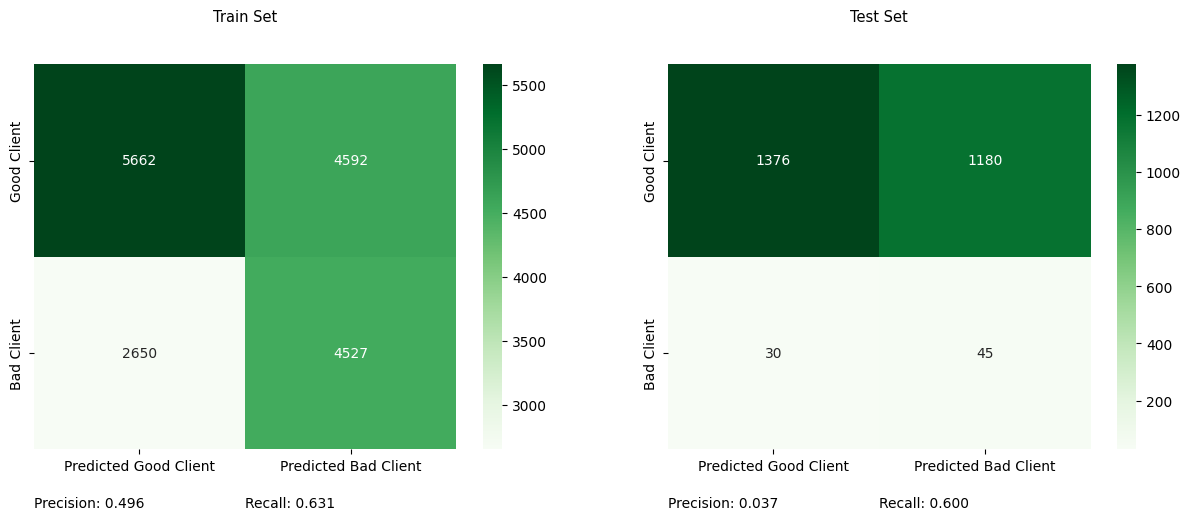

In [194]:
log_reg_smt, report_train_smt, report_test_smt = perform_logistic_regression(X_train_std_smt, y_train_smote, X_test_std, y_test, class_weight='balanced')

Train Set Accuracy:  0.59
              precision    recall  f1-score   support

           0       0.61      0.82      0.70       357
           1       0.55      0.29      0.38       268

    accuracy                           0.59       625
   macro avg       0.58      0.56      0.54       625
weighted avg       0.58      0.59      0.56       625

--------------------
Test Set Accuracy:  0.79
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2556
           1       0.04      0.24      0.06        75

    accuracy                           0.79      2631
   macro avg       0.50      0.52      0.47      2631
weighted avg       0.95      0.79      0.86      2631



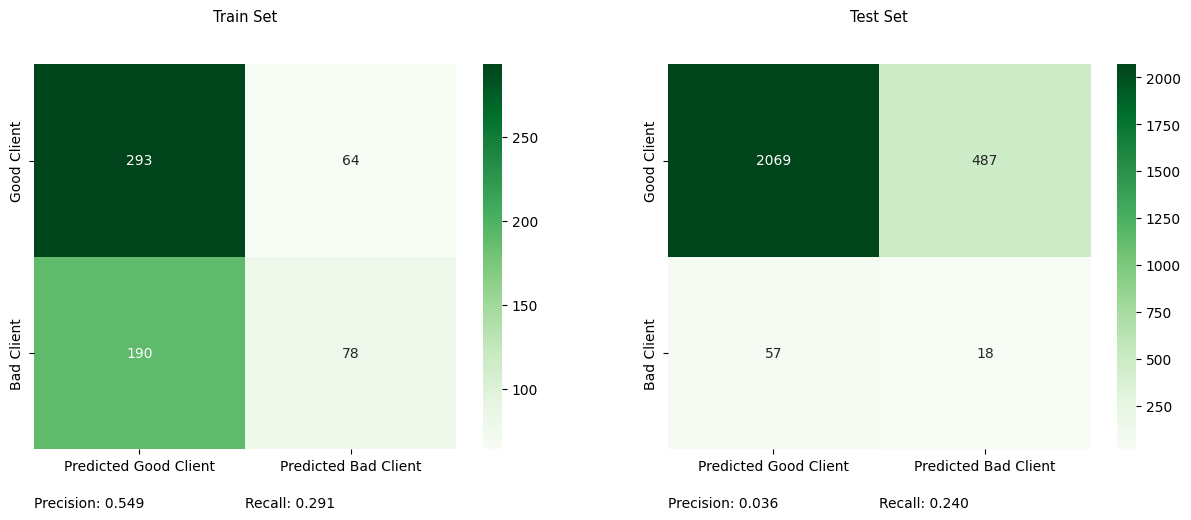

In [195]:
log_reg_ru = perform_logistic_regression(X_train_stdrus, y_train_rus, X_test_std, y_test)

In [196]:
smote = SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE)
X_train_std_smt03, y_train_smt03 = smote.fit_resample(X_train_std, y_train)
under = RandomUnderSampler(sampling_strategy=.15, random_state=RANDOM_STATE)
X_train_std_smt03rus, y_train_smt03rus = under.fit_resample(X_train_std_smt03, y_train_smt03)

print(y_train_smt03rus.value_counts())
print(X_train_std_smt03rus.shape)

BAD_CUSTOMER
0    10253
1     1538
Name: count, dtype: int64
(11791, 12)


Train Set Accuracy:  0.61
              precision    recall  f1-score   support

           0       0.89      0.62      0.73     10253
           1       0.17      0.51      0.25      1538

    accuracy                           0.61     11791
   macro avg       0.53      0.57      0.49     11791
weighted avg       0.80      0.61      0.67     11791

--------------------
Test Set Accuracy:  0.61
              precision    recall  f1-score   support

           0       0.98      0.61      0.75      2556
           1       0.04      0.53      0.07        75

    accuracy                           0.61      2631
   macro avg       0.51      0.57      0.41      2631
weighted avg       0.95      0.61      0.73      2631



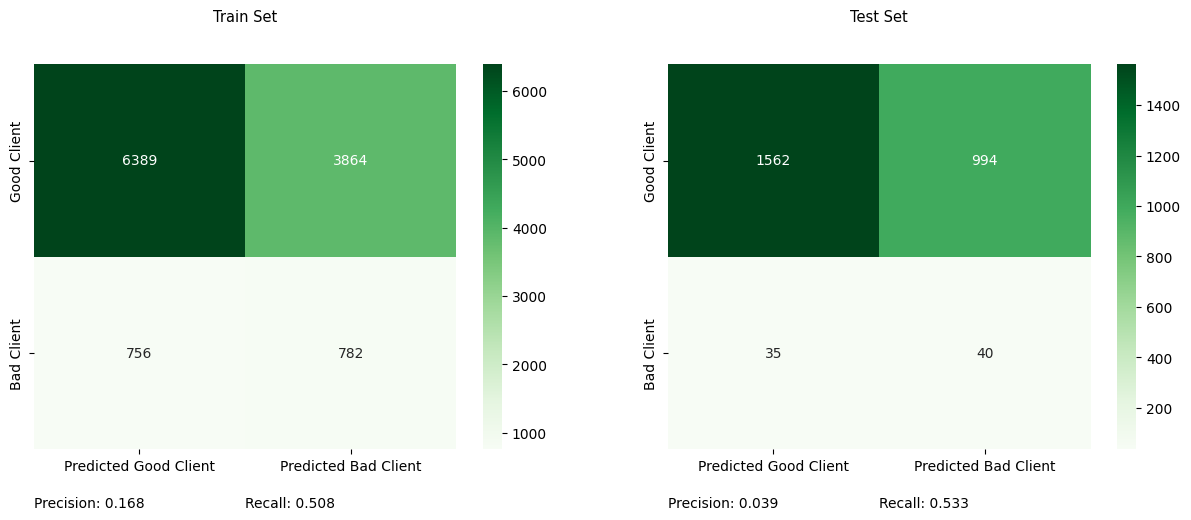

In [197]:
log_reg_smt03rus = perform_logistic_regression(X_train_std_smt03rus, y_train_smt03rus, X_test_std, y_test, class_weight='balanced', threshold=0.5)

In [198]:
X_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,...,EDUCATION_TYPE_Incomplete higher,EDUCATION_TYPE_Lower secondary,EDUCATION_TYPE_Secondary / secondary special,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
11443,0,1,0,1,0,0,0,1,0,0,...,0,0,1,90000,53,7,0,0,0,2
9752,0,1,0,1,0,0,0,0,0,1,...,0,0,0,157500,55,0,1,1,0,2
5632,0,1,1,0,0,0,0,0,0,0,...,0,0,1,189000,37,0,0,1,0,4
7700,0,1,0,1,0,0,0,0,1,0,...,0,0,1,90000,60,0,0,0,1,2
9208,0,1,0,1,0,0,0,0,0,0,...,0,0,1,157500,36,4,0,0,0,3


In [199]:
rnd_forest = BalancedRandomForestClassifier(random_state=RANDOM_STATE,
    replacement=True, bootstrap=True, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt'],
    'sampling_strategy': [0.5, 0.75, 1.]
}
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
    grid_search_1 = GridSearchCV(rnd_forest, param_grid, cv=cv,  n_jobs=-1)
grid_search_1.fit(X_train_rf, y_train)

print(grid_search_1.best_params_)


{'max_features': 'sqrt', 'n_estimators': 500, 'sampling_strategy': 0.5}


In [200]:
best_rnd_forest = grid_search_1.best_estimator_
best_rnd_forest.fit(X_train_rf, y_train)
y_pred_train = np.where(best_rnd_forest.predict_proba(X_train_rf)[:,1]>0.5, 1, 0)
y_pred = np.where(best_rnd_forest.predict_proba(X_test_rf)[:,1]>0.5, 1, 0)
accuracy_score(y_test, y_pred)

0.9034587609274041

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     10254
           1       0.27      1.00      0.42       268

    accuracy                           0.93     10522
   macro avg       0.63      0.96      0.69     10522
weighted avg       0.98      0.93      0.95     10522

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2556
           1       0.14      0.48      0.22        75

    accuracy                           0.90      2631
   macro avg       0.56      0.70      0.58      2631
weighted avg       0.96      0.90      0.93      2631



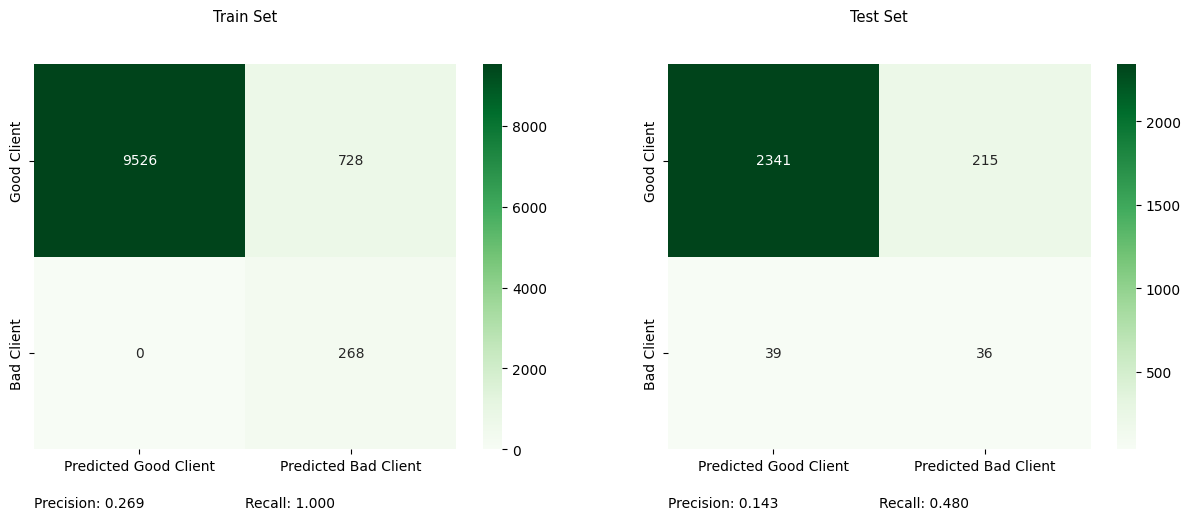

In [201]:
report_train_rf = classification_report(y_train, y_pred_train)
report_test_rf = classification_report(y_test, y_pred)
print(report_train_rf)
print(report_test_rf)
print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [202]:
balanced_model = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(), replacement=True, random_state=RANDOM_STATE, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_samples': [0.75, 1.],
    'max_features': [0.5, 0.75, 1.]
}
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(balanced_model, param_grid, cv=cv, n_jobs=-1)

grid_search.fit(X_train_rf, y_train)
print(grid_search.best_params_)


{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 500}


              precision    recall  f1-score   support

           0       1.00      0.92      0.96     10254
           1       0.24      1.00      0.38       268

    accuracy                           0.92     10522
   macro avg       0.62      0.96      0.67     10522
weighted avg       0.98      0.92      0.94     10522

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2556
           1       0.14      0.51      0.22        75

    accuracy                           0.90      2631
   macro avg       0.56      0.71      0.58      2631
weighted avg       0.96      0.90      0.92      2631



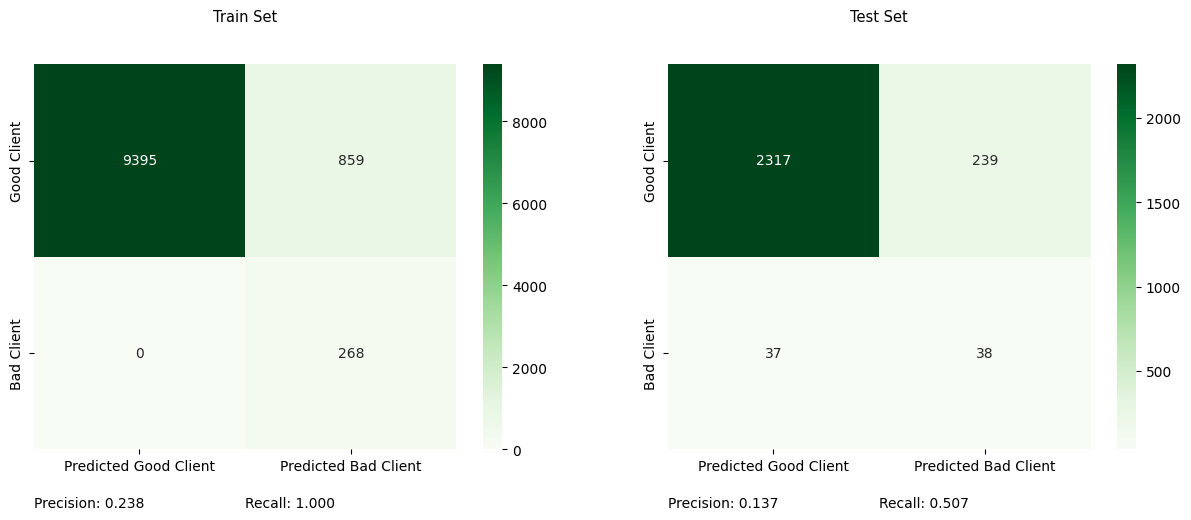

In [203]:
best_balanced_model = grid_search.best_estimator_
best_balanced_model.fit(X_train_rf, y_train)

y_pred_train = np.where(best_balanced_model.predict_proba(X_train_rf)[:,1]>0.525, 1, 0)
y_pred = np.where(best_balanced_model.predict_proba(X_test_rf)[:,1]>0.525, 1, 0)
accuracy_score(y_test, y_pred)

report_train_bb = classification_report(y_train, y_pred_train)
report_test_bb = classification_report(y_test, y_pred)
print(report_train_bb)
print(report_test_bb)

print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [204]:
norm_transformer = ColumnTransformer([
    ('NORM', MinMaxScaler(), columns_to_scale)
    ], 
    remainder='passthrough')

norm_transformer.set_output(transform='pandas')
X_train_norm = norm_transformer.fit_transform(X_train_rf)
X_test_norm = norm_transformer.transform(X_test_rf)
rename_column_without_prefix(X_train_norm, X_test_norm, prefix="remainder__")
X_train_norm.head()

,NORM__AMT_INCOME_TOTAL,NORM__AGE,NORM__YEARS_EMPLOYED,NORM__CNT_FAM_MEMBERS,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_TYPE_Pensioner,INCOME_TYPE_Student,EDUCATION_TYPE_Academic degree,FAMILY_STATUS_Married,FAMILY_STATUS_Single / not married,EDUCATION_TYPE_Higher education
11443,0.040698,0.673913,0.166667,0.071429,0,1,0,0,0,1,0,0
9752,0.084302,0.717391,0.000000,0.071429,0,1,0,0,0,1,0,1
5632,0.104651,0.326087,0.000000,0.214286,0,1,0,0,0,0,0,0
7700,0.040698,0.826087,0.000000,0.071429,0,1,1,0,0,1,0,0
9208,0.084302,0.304348,0.095238,0.142857,0,1,0,0,0,1,0,0


In [205]:
smote = SMOTE(sampling_strategy=0.3, random_state=RANDOM_STATE)
X_train_norm_smt03, y_train_norm_smt03 = smote.fit_resample(X_train_norm, y_train)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_train_norm_smt03rus, y_train_norm_smt03rus = under.fit_resample(X_train_norm_smt03, y_train_norm_smt03)

print(y_train_norm_smt03rus.value_counts())
print(X_train_norm_smt03rus.shape)


mlp = MLPClassifier(hidden_layer_sizes=(100, 150, 225), max_iter=1000, random_state=RANDOM_STATE)
mlp.fit(X_train_norm_smt03rus, y_train_norm_smt03rus)
y_pred = mlp.predict(X_test_norm)
accuracy_score(y_test, y_pred)


BAD_CUSTOMER
0    6152
1    3076
Name: count, dtype: int64
(9228, 12)


0.8859749144811858

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      6152
           1       0.88      0.95      0.91      3076

    accuracy                           0.94      9228
   macro avg       0.93      0.94      0.93      9228
weighted avg       0.94      0.94      0.94      9228

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2556
           1       0.10      0.37      0.16        75

    accuracy                           0.89      2631
   macro avg       0.54      0.64      0.55      2631
weighted avg       0.95      0.89      0.92      2631



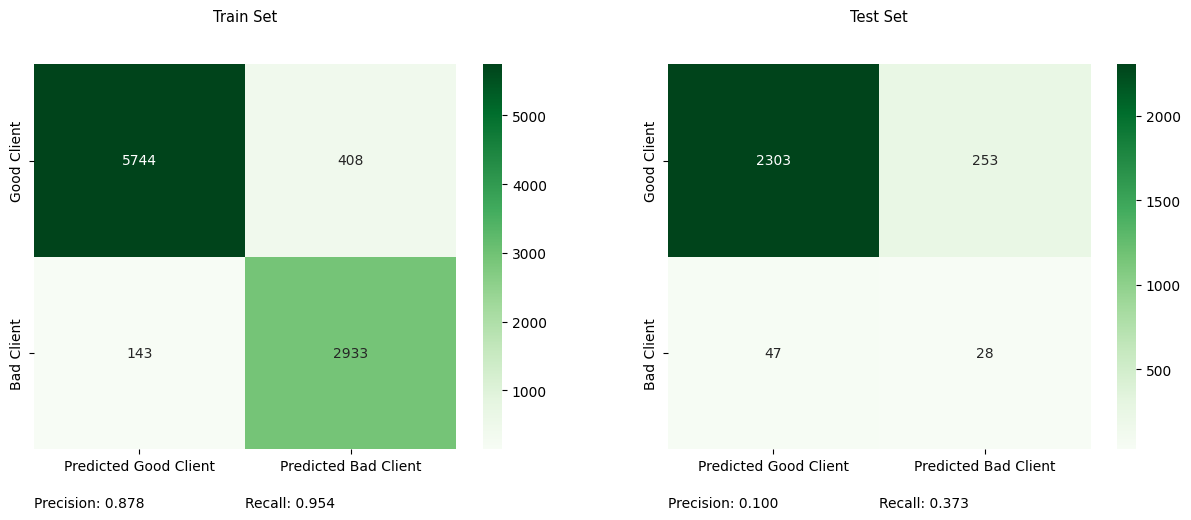

In [206]:
y_pred_train = np.where(mlp.predict_proba(X_train_norm_smt03rus)[:,1]>0.5, 1, 0)
y_pred = np.where(mlp.predict_proba(X_test_norm)[:,1]>0.5, 1, 0)
           

report_train_mlp = classification_report(y_train_norm_smt03rus, y_pred_train)
report_test_mlp = classification_report(y_test, y_pred)
print(report_train_mlp)
print(report_test_mlp)
print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train_norm_smt03rus, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [207]:
y_pred = np.where(best_balanced_model.predict_proba(X_test_rf)[:,1]>0.525, 1, 0)
correctly_classified_customers = approved_applications.loc[y_test[y_test == y_pred].index]

bad_client_classified = correctly_classified_customers[correctly_classified_customers['BAD_CUSTOMER'] == 1]

from sklearn.inspection import permutation_importance

result = permutation_importance(best_balanced_model, X_test_rf, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)


Permutation Importance:  [ 0.00760167  0.00935006  0.00805777 -0.00254656  0.01987837  0.02067655
 -0.00231851  0.          0.          0.00174838  0.004561    0.00178639]


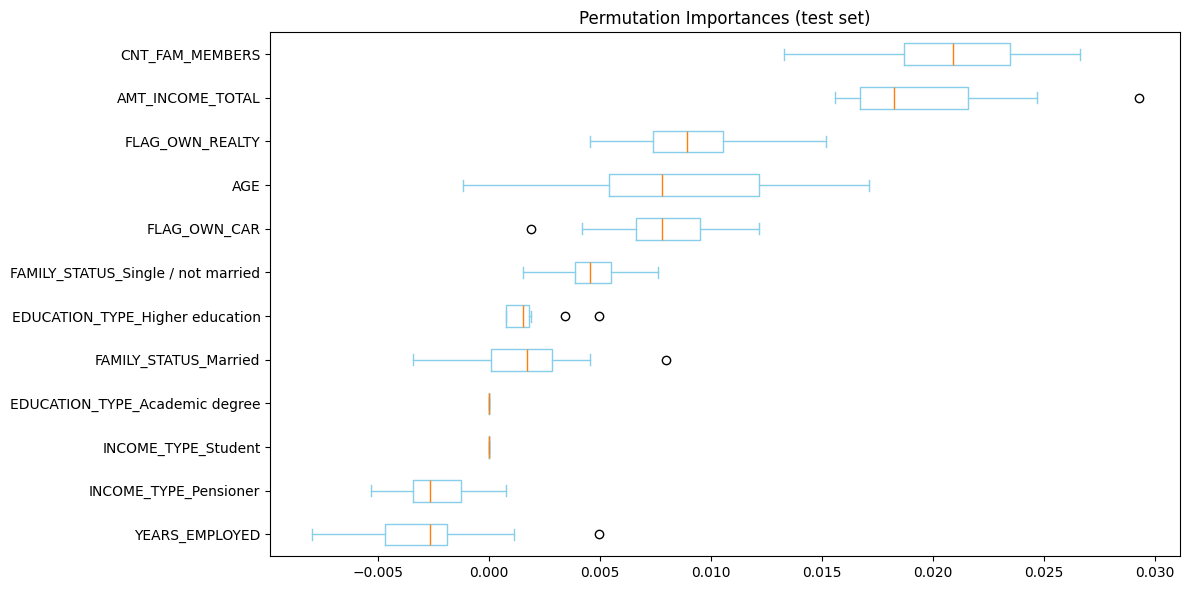

In [208]:
print("Permutation Importance: ", result.importances_mean)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test_rf.columns[sorted_idx], 
           boxprops=dict(color="skyblue"), whiskerprops=dict(color="skyblue"), capprops=dict(color="skyblue"))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


/home/enrmic/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but BalancedBaggingClassifier was fitted with feature names
  warnings.warn(


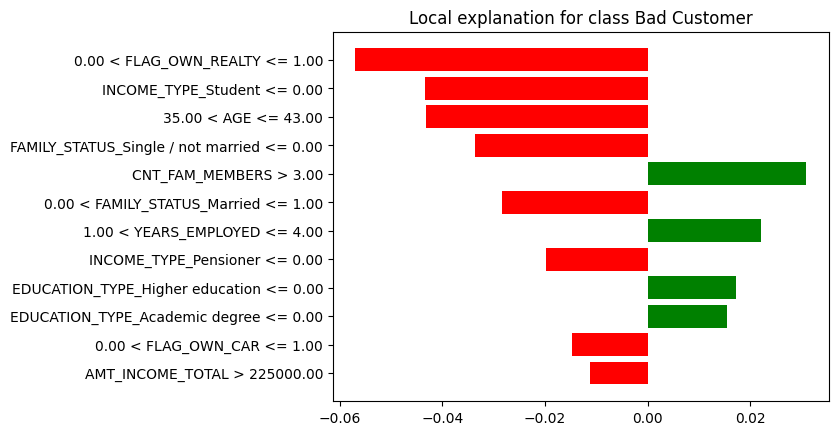

In [209]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_rf.values, feature_names=X_train_rf.columns, class_names=["Good Customer", "Bad Customer"], mode='classification', random_state=RANDOM_STATE)

idx = 0
exp = explainer.explain_instance(X_test_rf.values[idx], best_balanced_model.predict_proba, num_features=len(X_test_rf.columns))

fig = exp.as_pyplot_figure()
plt.show()

There are several methods you can use to explain feature importance for a classification model. Some commonly used techniques include:

Feature Importance Scores: Many machine learning algorithms provide a built-in method to calculate feature importance scores. For example, decision trees and ensemble methods like Random Forest and Gradient Boosting typically offer feature importance scores based on how much they contribute to reducing impurity (e.g., Gini impurity or entropy).

Permutation Importance: This method involves permuting the values of each feature one at a time and observing how it affects the model's performance. Features that, when permuted, lead to the largest increase in model error are considered the most important.

Partial Dependence Plots: These plots show the relationship between a feature and the predicted outcome while marginalizing the effects of all other features. They can help visualize how the prediction changes as the value of a single feature varies.

SHAP (SHapley Additive exPlanations): SHAP values provide a way to estimate the contribution of each feature to the model's prediction. They are based on cooperative game theory and provide a unified approach to explain the output of any machine learning model.

LIME (Local Interpretable Model-agnostic Explanations): LIME explains the predictions of any classifier by approximating it with an interpretable model (such as linear regression) in the local neighborhood of the instance being explained.

ELI5 (Explain Like I'm 5): ELI5 is a Python library that provides a simple interface for explaining machine learning models. It supports various explanation methods, including permutation importance, LIME, and more.

Feature Contribution: For linear models, you can directly interpret feature coefficients as their contributions to the prediction. Features with larger coefficients are considered more important.

Each of these methods has its advantages and disadvantages, and the choice depends on factors such as the complexity of the model, the interpretability needed, and the specific characteristics of the data. It's often useful to explore multiple methods to gain a comprehensive understanding of feature importance in your classification model.